In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix, hstack
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

%matplotlib inline

In [67]:
train_df = pd.read_csv('train.csv', sep='\t', low_memory=False)
test_df = pd.read_csv('test.csv', sep='\t', low_memory=False)

In [68]:
train_df.head()

,id,name,description,target
0,0,Заведующий отделом/секцией в магазин YORK (Уру...,<p><strong>В НОВЫЙ МАГАЗИН YORK (хозтовары) пр...,1
1,1,Наладчик станков и манипуляторов с ПУ,Обязанности:работа на токарных станках с ЧПУ T...,0
2,2,Разработчик С++ (Криптограф),<strong>Требования:</strong> <ul> <li>Опыт про...,0
3,3,Фрезеровщик,<p>Условия:</p> <ul> <li>На работу вахтовым ме...,0
4,4,Мерчендайзер/продавец-консультант,<p><strong>Компания Палладиум Стандарт - призн...,1


In [69]:
train_df.shape[0], test_df.shape[0]

(200000, 170179)

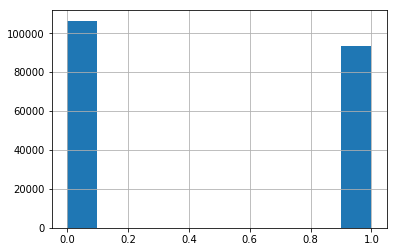

In [70]:
train_df['target'].hist();

In [71]:
test_df.head()

,id,name,description
0,200000,Дизайнер-консультант мебели,<p><strong>Обязанности:</strong></p> <ul> <li>...
1,200001,Продавец-консультант (ТЦ на Пушкина),<p><strong>Обязанности</strong>:</p> <p>∙ конс...
2,200002,Менеджер по продажам,<p>Торговый Дом «Форт» это ведущая компания Пе...
3,200003,Продавец-консультант в магазин одежды (ТЦ Волн...,<p><strong>Требуются продавцы консультанты в м...
4,200004,Специалист по охране труда,<strong>Обязанности:</strong> <ul> <li> <p>осу...


In [72]:
def clean_html(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

train_df['description'] = train_df['description'].apply(lambda x: clean_html(x))
test_df['description'] = test_df['description'].apply(lambda x: clean_html(x))

In [73]:
y = train_df['target']
X = train_df.drop(['id', 'target'], axis=1)
X_test = test_df.drop(['id'], axis=1)

In [159]:
%%time
tf_idf_1 = TfidfVectorizer(ngram_range=(1, 4), max_features=25000)
tf_idf_2 = TfidfVectorizer(ngram_range=(1, 5), max_features=50000)
X_name = tf_idf_1.fit_transform(X.name)
X_desc = tf_idf_2.fit_transform(X.description)
X_transformed = csr_matrix(hstack([X_name, X_desc]))

X_test_transformed = csr_matrix(hstack([tf_idf_1.transform(X_test.name), 
                                        tf_idf_2.transform(X_test.description)]))

Wall time: 6min 42s


In [160]:
X_train, X_valid, y_train, y_valid = train_test_split(X_transformed, y, test_size=0.3, random_state=15)

In [161]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

In [162]:
%%time
logreg = LogisticRegression(random_state=15)
lgb = LGBMClassifier(n_estimators=670, learning_rate=0.09, num_leaves=53, min_child_samples = 10, random_state = 15)
cv = cross_val_score(logreg, X_train, y_train, scoring='roc_auc', n_jobs=-1, cv=skf)

Wall time: 21.8 s


In [163]:
cv.mean()

0.9924950449909857

In [164]:
%%time
logit_c_values = np.linspace(0.01, 10, 20)

logit_grid_searcher = LogisticRegressionCV(Cs=logit_c_values, cv=skf, random_state=15, n_jobs=-1, scoring='roc_auc')
logit_grid_searcher.fit(X_train, y_train)

Wall time: 5min 27s


c:\users\kmsim\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [165]:
logit_mean_cv_scores = np.zeros(len(logit_c_values))
for i in logit_grid_searcher.scores_[1]: 
    logit_mean_cv_scores  += np.array(i)          
logit_mean_cv_scores = logit_mean_cv_scores / 5            

print('Лучшее значение ROC AUC для LogisticRegression: {}, при параметре C: {}'.format('%.6f' % logit_mean_cv_scores.max(), 
                                                                '%.3f' % logit_grid_searcher.Cs_[logit_mean_cv_scores.argmax()]))

Лучшее значение ROC AUC для LogisticRegression: 0.992999, при параметре C: 3.165


In [166]:
logit = LogisticRegression(C=logit_grid_searcher.Cs_[logit_mean_cv_scores.argmax()], random_state=15, n_jobs=-1)
y_pred_logit = logit.fit(X_transformed, y).predict_proba(X_test_transformed)[:,1]

c:\users\kmsim\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\kmsim\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


In [167]:
submission = pd.read_csv('sampleSubmission.csv')
submission.shape

(170179, 2)

In [168]:
submission['target'] = y_pred_logit
submission.to_csv('logit_grid_html_split_ngram(1_4_1_5)_25_50k.csv', index=False)